<a href="https://colab.research.google.com/github/JonasSouza871/fruit_classifier_cnn/blob/main/fruit_classifier_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.  Treinamento da rede

-----------------

## 1.1 Carregamento dos dados do dataset

-----

In [ ]:
!pip install kagglehub tensorflow pillow numpy matplotlib scikit-learn seaborn #dependências

- Importar biblioteca

In [ ]:
import kagglehub
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [ ]:
# Download do dataset
path = kagglehub.dataset_download("moltean/fruits")
train_dir = None #diretorio de treino
test_dir = None #diretorio de teste

#Como o dataset está separado em imagens de treino e teste por pastas diferentes, temos que procurar os diretorios de treino (Train_dir) e teste(test_dir)
for root, dirs, files in os.walk(path):
    if '100x100' in root.lower():
        for d in dirs:
            full_path = os.path.join(root, d)
            if 'train' in d.lower() and train_dir is None:
                try:
                    if len([c for c in os.listdir(full_path) if os.path.isdir(os.path.join(full_path, c))]) > 10:
                        train_dir = full_path
                except:
                    pass
            if 'test' in d.lower() and test_dir is None:
                try:
                    if len([c for c in os.listdir(full_path) if os.path.isdir(os.path.join(full_path, c))]) > 10:
                        test_dir = full_path
                except:
                    pass
    if train_dir and test_dir:
        break

print(f"Diretório de Treino /validaçãop: {train_dir}")
print(f"Diretório de teste: {test_dir}")

Using Colab cache for faster access to the 'fruits' dataset.
Diretório de Treino /validaçãop: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training
Diretório de teste: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Test


In [ ]:
classes_finais = [ #classes selecionadas para o modelo treinar
    'Apple Golden 1',
    'Apple Red 1',
    'Strawberry 1',
    'Peach 1',
    'Pineapple 1',
    'Orange 1',
    'Lemon 1',
    'Mango 1',
    'Banana 1',
    'Pear 1'
]
print("CLASSES SELECIONADAS:")
val_split = 0.2

for i, classe in enumerate(classes_finais, 1): #para todas as classes
    train_path = os.path.join(train_dir, classe) #verifica as imagens de treino de cada classe no repositorio de treino
    test_path = os.path.join(test_dir, classe) #verifica as imagens de teste de cada classe no repositorio de teste
    total_train = len([f for f in os.listdir(train_path) if f.lower().endswith(('.jpg', '.png'))]) #total de imagens no train_dir
    train_imgs = int(total_train * (1 - val_split)) #80% para treino
    val_imgs = total_train - train_imgs #20% para validação
    test_imgs = len([f for f in os.listdir(test_path) if f.lower().endswith(('.jpg', '.png'))]) #verifica a quantidade de imagem de teste para cada classe
    print(f"{i:2d}. {classe:30s} | Treino: {train_imgs:4d} | Validação: {val_imgs:4d} | Teste: {test_imgs:4d}")

CLASSES SELECIONADAS:
 1. Apple Golden 1                 | Treino:  384 | Validação:   96 | Teste:  160
 2. Apple Red 1                    | Treino:  393 | Validação:   99 | Teste:  164
 3. Strawberry 1                   | Treino:  393 | Validação:   99 | Teste:  164
 4. Peach 1                        | Treino:  393 | Validação:   99 | Teste:  164
 5. Pineapple 1                    | Treino:  392 | Validação:   98 | Teste:  166
 6. Orange 1                       | Treino:  383 | Validação:   96 | Teste:  160
 7. Lemon 1                        | Treino:  393 | Validação:   99 | Teste:  164
 8. Mango 1                        | Treino:  392 | Validação:   98 | Teste:  166
 9. Banana 1                       | Treino:  392 | Validação:   98 | Teste:  166
10. Pear 1                         | Treino:  393 | Validação:   99 | Teste:  164


## 1.2. Configuração do modelo de treino

-------

In [ ]:
IMG_SIZE = 100 #tamanho da imagem
BATCH_SIZE = 32
EPOCHS = 100  #quantidade de epocas
LEARNING_RATE = 0.0001 #taxa de aprendizado

# Data augmentation para treino/validação
#preparação da imagem para treinamento
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2 #validação considerando 20% dos dados totais
)
# Data generator para teste (apenas rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Gerador de treino
train_generator = datagen.flow_from_directory(
    train_dir, #pega as iamgens no diretorio de trieno
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training', # subsset de trieno
    classes=classes_finais, #com base nas classes definidos acima
    shuffle=True,
    seed=42 #garantir reprodutibilidade
)

# Gerador de validação
validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    classes=classes_finais,
    shuffle=False,
    seed=42
)

# Gerador de teste
test_generator = test_datagen.flow_from_directory(
    test_dir, #usa o diretorio separado para os dados de test do proprio dataset
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes_finais,
    shuffle=False
)

# Informações sobre a divisão dos dados
num_classes = len(classes_finais)
print("DIVISÃO DOS DADOS:")
print(f"Treino:     {train_generator.samples:,} imagens ({train_generator.samples/(train_generator.samples+validation_generator.samples)*100:.1f}%)") #separa os dadops de cada classe que serão para treino (definido para 80%)
print(f"Validação:  {validation_generator.samples:,} imagens ({validation_generator.samples/(train_generator.samples+validation_generator.samples)*100:.1f}%)") #separa os dados de cada classe que serão para validação (definido para)
print(f"Classes:    {num_classes}")

# Salvar labels
labels = {v: k for k, v in train_generator.class_indices.items()} #labels atraves do treino
with open('labels.json', 'w') as f:
    json.dump(labels, f, indent=2)

Found 3914 images belonging to 10 classes.
Found 975 images belonging to 10 classes.
Found 1638 images belonging to 10 classes.
DIVISÃO DOS DADOS:
Treino:     3,914 imagens (80.1%)
Validação:  975 imagens (19.9%)
Classes:    10


## 1.3. Arquitetura da CNN

-----

In [ ]:
#Construção da arquitetura CNN
model = keras.Sequential([
    #camadas convolucionais 2d com atiavação via relu e maxpooling
    layers.Conv2D(8, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2), #dropout para melhor a generalização do modelo
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(32, activation='relu'), #camada simples ao final
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax') #camada final aplicando ativação com SOFTMAX
])

# Compilação do modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), #otimizador ADAM
    #metricas que irão ser avlaiadas
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 98, 98, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 49, 49, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 47, 47, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 21, 21, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │       102,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,794 (424.98 KB)

 Trainable params: 108,794 (424.98 KB)

 Non-trainable params: 0 (0.00 B)

## 1.4. Configuração de Callbacks e Treinamento

-----

In [ ]:
# Callbacks para controle do treinamento
early_stop = EarlyStopping( #parada precose se o modelo não evoluir por 10 epocas
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau( #reduz automaticamente a taxa de aprendizado (learning rate) quando o modelo para de melhorar na métrica que você está monitorando
    monitor='val_loss',#metrica a ser avaliada
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stop, reduce_lr] #parametros de controle
history = model.fit( #ativa o treinamento do modelo
    train_generator, #dados de treino
    epochs=EPOCHS, #epocas que serao utilizadas
    validation_data=validation_generator, #dados de validação
    callbacks=callbacks #callbacks de controle q irão aocmpanhar o modelo
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 75s 424ms/step - accuracy: 0.1390 - loss: 2.2576 - val_accuracy: 0.3662 - val_loss: 2.0394 - learning_rate: 1.0000e-04
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.2927 - loss: 1.9239 - val_accuracy: 0.6000 - val_loss: 1.4861 - learning_rate: 1.0000e-04
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 25s 207ms/step - accuracy: 0.4608 - loss: 1.4668 - val_accuracy: 0.7395 - val_loss: 0.9660 - learning_rate: 1.0000e-04
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - accuracy: 0.5591 - loss: 1.1579 - val_accuracy: 0.8626 - val_loss: 0.6947 - learning_rate: 1.0000e-04
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 217ms/step - accuracy: 0.6423 - loss: 0.9470 - val_accuracy: 0.8913 - val_loss: 0.5348 - learning_rate: 1.0000e-04
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - accuracy: 0.6883 - loss: 0.8258 - val_accuracy: 0.8687 - val_loss: 0.4496 - learning_rate: 1.0000e-04
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━

# 1.5. Plotagens e visualização das métricas de treinamento

--------------

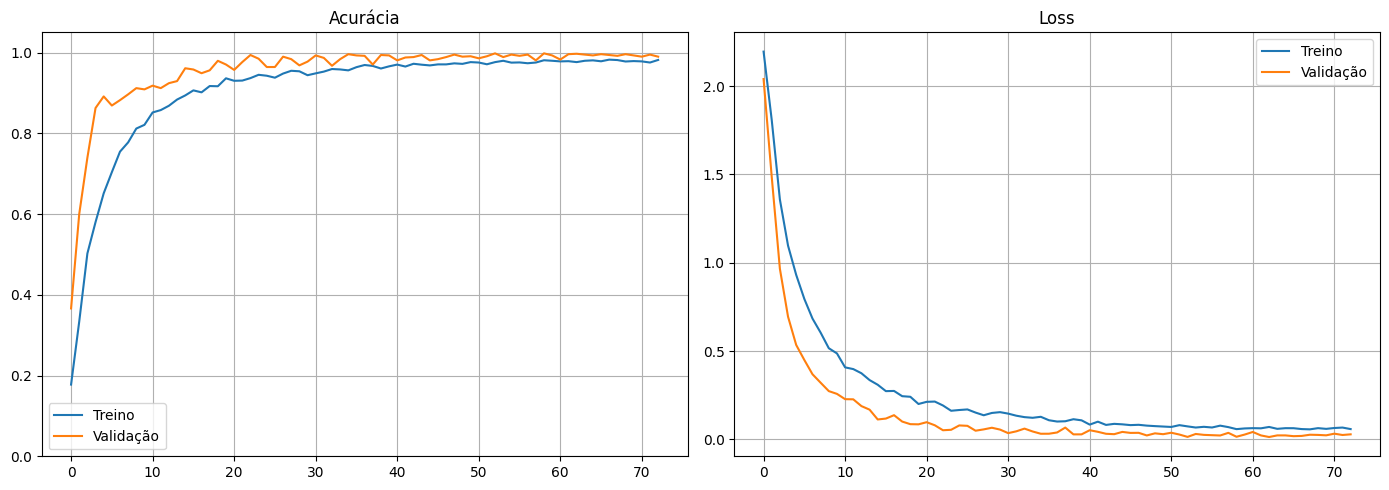

In [ ]:
# Plotagem das curvas de aprendizado
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Avaliação do modelo no conjunto de teste
test_loss, test_accuracy = model.evaluate(test_generator) #aaplica os resultados dos dados de treino (validação e treino) no dataset de teste
print("RESULTADO NO CONJUNTO DE TESTE:")
print(f"Loss:     {test_loss:.4f}")
print(f"Acurácia: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)") #acuracia em %

52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.8973 - loss: 0.1752
RESULTADO NO CONJUNTO DE TESTE:
Loss:     0.1152
Acurácia: 0.9475 (94.75%)


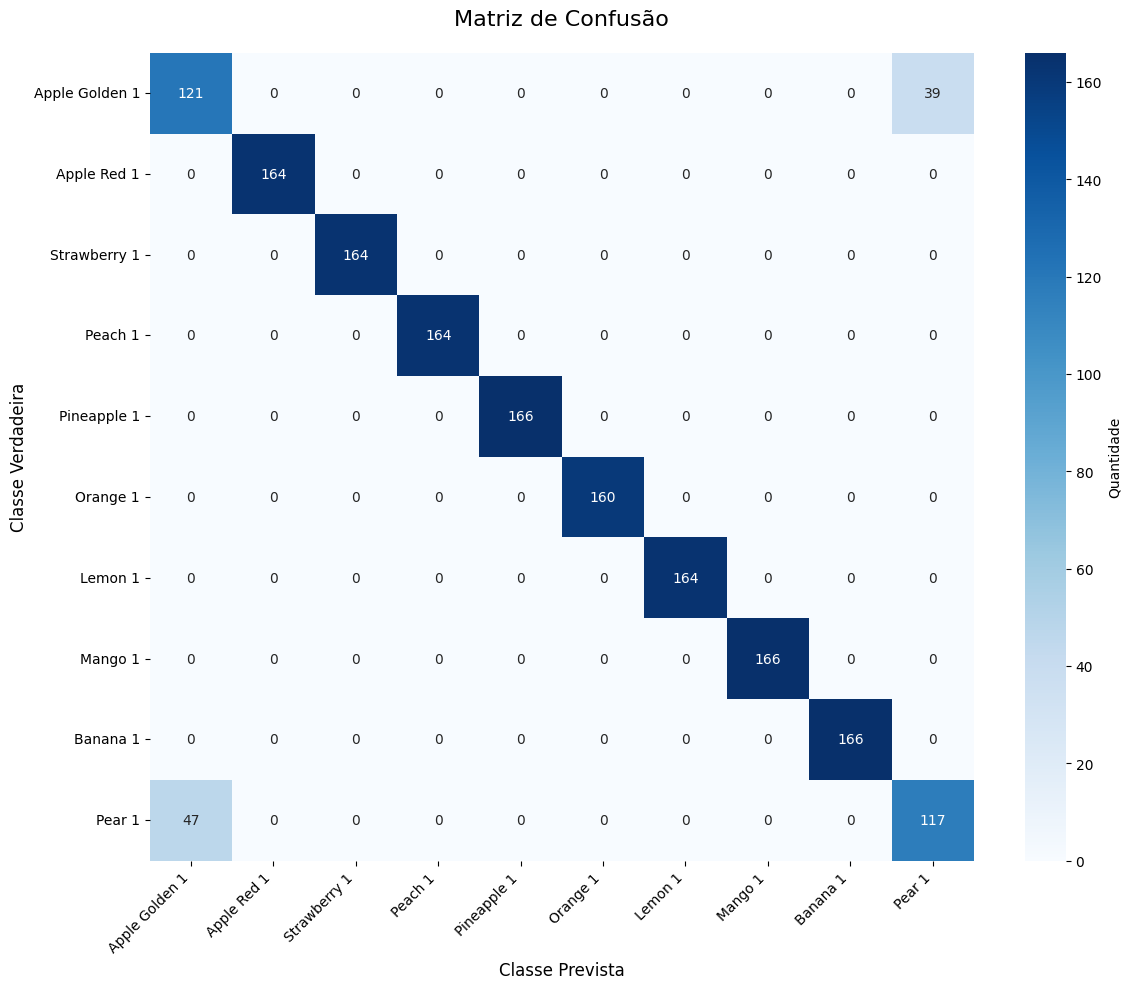

In [ ]:
# Gerando predições para análise detalhada
test_generator.reset()
y_pred = [] #classe de previsao do modelo
y_true = [] #classe verdadeira apartir das labels

for i in range(len(test_generator)): #para todas as imagens do dataset de teste
    x_batch, y_batch = next(test_generator) #x_batch → um lote de imagens (ex: 32 imagens 150x150),  y_batch → os rótulos one-hot correspondentes a essas imagens
    predictions = model.predict(x_batch, verbose=0) #O modelo faz as previsões para todas as imagens do batch.
    y_pred.extend(np.argmax(predictions, axis=1)) #pega a classe de maior probabilidade para cada imagem.
    y_true.extend(np.argmax(y_batch, axis=1)) #converte todos one-hot da labels em classe verdadeira (O que de fato é)

#cria array
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred) #vai compara o que foi previsto pelo modelo apartir da predição de cada imagem e o que é verdade apartir das labels reais

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes_finais,
            yticklabels=classes_finais,
            cbar_kws={'label': 'Quantidade'})
plt.title('Matriz de Confusão', fontsize=16, pad=20)
plt.ylabel('Classe Verdadeira', fontsize=12)
plt.xlabel('Classe Prevista', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Relatório de classificação completo
print("RELATÓRIO DE CLASSIFICAÇÃO:")
print(classification_report(y_true, y_pred, target_names=classes_finais, digits=4)) #f1 score, recall, acuracia ..

print("\nACURÁCIA POR CLASSE:")
for i, cls in enumerate(classes_finais): # para cada classe irá fazer uma analise completa dos resultados aparitr da acuracia
    cls_mask = y_true == i
    cls_acc = np.mean(y_pred[cls_mask] == y_true[cls_mask])
    total = np.sum(cls_mask)
    corretos = np.sum(y_pred[cls_mask] == y_true[cls_mask])
    print(f"{cls:30s} | {corretos:3d}/{total:3d} | {cls_acc*100:5.2f}%")

RELATÓRIO DE CLASSIFICAÇÃO:
                precision    recall  f1-score   support

Apple Golden 1     0.7202    0.7562    0.7378       160
   Apple Red 1     1.0000    1.0000    1.0000       164
  Strawberry 1     1.0000    1.0000    1.0000       164
       Peach 1     1.0000    1.0000    1.0000       164
   Pineapple 1     1.0000    1.0000    1.0000       166
      Orange 1     1.0000    1.0000    1.0000       160
       Lemon 1     1.0000    1.0000    1.0000       164
       Mango 1     1.0000    1.0000    1.0000       166
      Banana 1     1.0000    1.0000    1.0000       166
        Pear 1     0.7500    0.7134    0.7312       164

      accuracy                         0.9475      1638
     macro avg     0.9470    0.9470    0.9469      1638
  weighted avg     0.9476    0.9475    0.9475      1638


ACURÁCIA POR CLASSE:
Apple Golden 1                 | 121/160 | 75.62%
Apple Red 1                    | 164/164 | 100.00%
Strawberry 1                   | 164/164 | 100.00%
Peach 1    

## 1.6. Salvando o modelo

------

In [ ]:
#Salvamento do modelo Keras
model.save('modelo_fruits.keras') #salva o modelo de treinamento no modelo Keras
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()# Conversão e salvamento do modelo TFLite

with open('modelo_fruits.tflite', 'wb') as f:
    f.write(tflite_model)

#Comparação de tamanhos de cada modelo keras e tflite
keras_size = os.path.getsize('modelo_fruits.keras') / 1024 / 1024
tflite_size = os.path.getsize('modelo_fruits.tflite') / 1024 / 1024
print(f"\nTamanho Keras:  {keras_size:.2f} MB")
print(f"Tamanho TFLite: {tflite_size:.2f} MB")
print(f"Redução:        {(1 - tflite_size/keras_size)*100:.1f}%")

#Download dos arquivos (apenas funciona no Colab)
try:
    from google.colab import files
    files.download('modelo_fruits.keras')
    files.download('modelo_fruits.tflite')
    files.download('labels.json')
    print("Download concluído!")
except:
    print("erro")

Saved artifact at '/tmp/tmprsjj68jo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor_104')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139109397479056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139109397473296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139109397474832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139109397469072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139107658546640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139107658538576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139107658546832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139107658545488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139107658544336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139107658545104: TensorSpec(shape=(), dtype=tf.resource, name=None)

Tamanho Ke

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download concluído!


# 2. Testando modelo com fotos externas

------

- A ideia aqui é que o usuário consiga upar uma imagem externa tirada por ele ou de outro site e que o modelo consiga prever qual fruta se trata.

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import json

interpreter = tf.lite.Interpreter(model_path='/content/modelo_fruits.tflite') # Carregar modelo TFLite e labels de cada classe
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
with open('labels.json', 'r') as f: #carrega os labels
    labels = json.load(f)

#Upload de imagem externa no colab
from google.colab import files
uploaded = files.upload() #armazena imagem enviada
#Processamento da imagem imagem
image_path = list(uploaded.keys())[0]
img = Image.open(image_path).convert('RGB')
img = img.resize((100, 100))
img_array = np.array(img, dtype=np.float32) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predição com TFLite
interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()
predictions = interpreter.get_tensor(output_details[0]['index'])[0] #faz a previsao com o modelo
predicted_class = np.argmax(predictions)  #prever a classe que o modelo pertence
confidence = predictions[predicted_class] #confiança de cada classe % de chance de pertecer a cada classe

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


ValueError: Could not open '/content/modelo_fruits (1).tflite'.

In [ ]:
print(f"Predição: {labels[str(predicted_class)]}")
print(f"Confiança: {confidence*100:.2f}%")

# Mostrar imagem upada
import matplotlib.pyplot as plt
plt.imshow(img)
plt.title(f"{labels[str(predicted_class)]} ({confidence*100:.1f}%)")
plt.axis('off')
plt.show()

# Top 3 predições
print("\nTop 3 predições:")
top3 = np.argsort(predictions)[-3:][::-1]
for i, idx in enumerate(top3, 1):
    print(f"{i}. {labels[str(idx)]}: {predictions[idx]*100:.2f}%")

# 3. Criar modelo TFLite leve para executar em hardware ARM

----------

In [ ]:
model = tf.keras.models.load_model('/content/modelo_fruits.keras') #modelo original keras

# Converter para TFLite targeting ops compatíveis
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]  #versão antiga
tflite_model = converter.convert()

# Salvar
with open("modelo_fruits_compat.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp1tpycqby'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_layer_8')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  134902318561616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134902318562960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134902313240528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134902313239568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134902313243408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134902313244176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134902313243600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134902313244752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134902313243024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134902313245904: TensorSpec(shape=(), dtype=tf.resource, name=None)
